# 进行基本的数据预处理：
## 

In [1]:
# 导入基本的依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json
try:
    from neuralprophet import save, load
except Exception:
    from neuralprophet.utils import save, load

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
np.random.seed(42)
is_test = False

/home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
def parse_epoch(series):
    max_val = series.max()
    if max_val > 1e15:
        ts = pd.to_datetime(series, unit='us', errors='coerce', utc=True)
    elif max_val > 1e12:
        ts = pd.to_datetime(series, unit='ms', errors='coerce', utc=True)
    else:
        ts = pd.to_datetime(series, unit='s', errors='coerce', utc=True)
    return ts

def json_to_dataframe(file_path,start_year="2025",start_month="5",start_day="13",
                      end_year="2025",end_month="06",end_day="22"):
    """
        将JSON文件转换为DataFrame格式
        :param file_path: JSON文件路径
    """
    # 将start_year, start_month, start_day, end_year, end_month, end_day转换为字符串
    start_date = f"{start_year}-{start_month}-{start_day}" if start_year and start_month and start_day else ""
    end_date = f"{end_year}-{end_month}-{end_day}" if end_year and end_month and end_day else ""
    # 选取两个日期之间所有的json文件
    all_json_list = os.listdir(file_path)
    print(f"所有的json文件: {len(all_json_list)}")
    conditional_json_list = []
    for json_file in all_json_list:
        if json_file.endswith('.json'):
            json_date = json_file.split('.')[0].split('_')[1]
            # print(f"正在处理文件: {json_date}")
            # print(json_date)
            if start_date and end_date:
                if start_date <= json_date <= end_date:
                    conditional_json_list.append(json_file)
    # 对所有的json文件进行遍历
    df_list = []
    for json_file in conditional_json_list:
        # print(f"正在处理文件: {json_file}")
        if json_file.endswith('.json'):
            file_path_full = os.path.join(file_path, json_file)
            # 跳过空文件
            if os.path.getsize(file_path_full) == 0:
                print(f"跳过空文件: {json_file}")
                continue
            # 检查文件是否存在
            if not os.path.exists(file_path_full):
                continue
            # 读取JSON文件
            with open(file_path_full, 'r', encoding='utf-8') as f:
                data = json.load(f)
            # print(f"正在处理文件: {json_file}")
            df_day = pd.DataFrame([data['stationStatisticDay']])
            df_power = pd.DataFrame(data['stationStatisticPowerList'])
            # 针对df_day 选取usevalue,buyvalue,fullpowerhours列的数据：
            df_day = df_day[['acPowerHours','fullPowerHours',"generationValue"]]
            # print(df_power)
            df_power = df_power.loc[:, ['dateTime', 'generationPower']] # generationCapacity
            empty_columns = df_day.columns[df_day.isnull().all()]
            if not empty_columns.empty:
                print(f"警告: 在文件 {json_file} 中，以下列全为空: {', '.join(empty_columns)}")
                # 如果存在空列，使用即使用df_list最后一个DataFrame的列名
                if df_list:
                    last_day_data = df_list[-1].iloc[0]
                    df_day[empty_columns] = last_day_data[empty_columns].values
                    print(f"已使用最后一个DataFrame的值填充空列: {', '.join(empty_columns)}")
                else:
                    print("没有可用的DataFrame来填充空列。")
                    #填充问题列为0
                    df_day[empty_columns] = 0
                    print(f"已将空列填充为0: {', '.join(empty_columns)}")
            # 将df_day和df_power合并,由于df_day只有一行数据，而df_power有多行数据，所以需要进行广播
            df_day = df_day.loc[df_day.index.repeat(len(df_power))].reset_index(drop=True)
            df_power = df_power.reset_index(drop=True)

            df_power = pd.concat([df_day, df_power], axis=1)
            # 将处理后的DataFrame添加到列表中
            df_list.append(df_power)
            # print(len(df_list))
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        # 将dateTime列转换为日期格式
        combined_df['dateTime'] = parse_epoch(combined_df['dateTime'])
        # 按需转换到 Asia/Shanghai 时区
        combined_df['dateTime'] = combined_df['dateTime'].dt.tz_convert('Asia/Shanghai')
        # 打印合并后的DataFrame的形状
        print(f"合并后的DataFrame形状: {combined_df.shape}")
        return combined_df
    else:
        print("没有有效的JSON文件可供处理。")
        return pd.DataFrame()





# file_path = "data_three_years"
station_id = 194
# file_path = f"./data/station_{station_id}"
file_path = f"/home/hao/Documents/功率预测0813/data/{station_id}"

# 取2023年10月1日到2024年5月5日之间的所有json文件作为一个训练集

X_train_1 = json_to_dataframe(file_path, start_year="2024", start_month="06", start_day="01",
                               end_year="2025", end_month="05", end_day="31")

X_test = json_to_dataframe(file_path, start_year="2025", start_month="06", start_day="02",
                           end_year="2025", end_month="07", end_day="02")


所有的json文件: 392
警告: 在文件 194_2024-09-07.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-10-07.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-06-20.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-09-22.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-06-08.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-08-03.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-10-16.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-09-23.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-09-20.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-12-14.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-10-13.json 中，以下列全为空: acPowerHours
已使用最后一个DataFrame的值填充空列: acPowerHours
警告: 在文件 194_2024-

<Axes: >

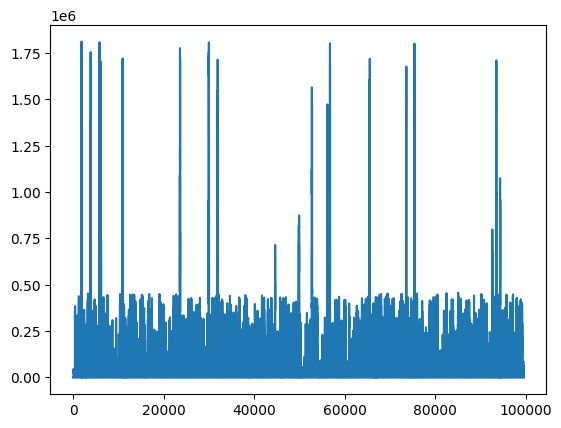

In [3]:
X_train_1["generationPower"].plot()

获取完pd.dataframe格式的数据之后构建数据集和测试集

In [4]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib #添加的

# 记录第一个子集长度，便于后续拆分
len_train_1 = len(X_train_1)

# 如果只用 X_train_1 做示例，合并成完整训练集
# X_train = pd.concat([X_train_1], ignore_index=True)
X_train = X_train_1.copy()
# 如果有多个子集：
# X_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4], ignore_index=True)

def preprocess_data(df, if_train=True, scalers=None):
    """
    改进后的预处理流程：
      - 确保 dateTime 列解析正确并带时区
      - 从 dateTime 提取时间特征
      - 生成 timestamp（秒级）而不丢失精度
      - 插值缺失值
      - 按物理量类别分别归一化
    """
    if scalers is None:
        scalers = {}

    # 1. 确保 dateTime 是 datetime 类型，并统一时区
    # if df['dateTime'].dtype == object or not pd.api.types.is_datetime64_any_dtype(df['dateTime']):
        # df['dateTime'] = pd.to_datetime(df['dateTime'], format="mixed", errors="coerce")  # 将无效时间戳转换为 NaT
    # df['dateTime'] = df['dateTime'].dt.tz_convert('Asia/Shanghai')

    # 处理 NaT 的情况，默认删除这些行（也可以选择填充）
    df = df.dropna(subset=['dateTime'])  # 删除含 NaT 的行
    # 如果不想删除，而是填充 NaT，可以使用插值或其他策略


    # 3. 时间特征提取
    print("步骤1: 时间特征提取")
    print(f"数据时间范围: {df['dateTime'].min()} 到 {df['dateTime'].max()}")
    df['hour']        = df['dateTime'].dt.hour.astype(int)
    df['day_of_week'] = df['dateTime'].dt.dayofweek.astype(int)
    df['month']       = df['dateTime'].dt.month.astype(int)
    df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)

    # 4. 生成 timestamp（秒级，不丢失精度）
    # df['timestamp'] = df['dateTime'].view('int64') // 10**9
    df["timestamp"] = df["dateTime"].astype(np.int64) // 10**12  # 转换为秒级时间戳


    # 5. 缺失值处理
    print("\n步骤2: 缺失值处理")
    print(f"缺失值统计:\n{df.isnull().sum()}")
    for col in ['generationPower', 'fullPowerHours']:
        df[col] = df[col].interpolate(method='linear')

    # 6. 分别归一化各类特征
    print("\n步骤3: 分别归一化不同物理量")
    power_feats    = ['generationPower']
    energy_feats   = ['generationValue']
    duration_feats = ['fullPowerHours']
    time_feats     = ['hour', 'day_of_week', 'month']

    if if_train:
        # 6.1 功率类：标准化
        scaler_p = StandardScaler()
        df[power_feats] = scaler_p.fit_transform(df[power_feats])
        scalers['power_scaler'] = scaler_p

        # 6.2 能量类：MinMax → [0,1]
        scaler_e = MinMaxScaler()
        df[energy_feats] = scaler_e.fit_transform(df[energy_feats])
        scalers['energy_scaler'] = scaler_e

        # 6.3 持续时长类：MinMax → [0,1]
        scaler_d = MinMaxScaler()
        df[duration_feats] = scaler_d.fit_transform(df[duration_feats])
        scalers['duration_scaler'] = scaler_d

        # 6.4 周期性时间：sin/cos 变换
        for feat in time_feats:
            maxv = {'hour':24, 'day_of_week':7, 'month':12}[feat]
            df[f'{feat}_sin'] = np.sin(2*np.pi*df[feat]/maxv)
            df[f'{feat}_cos'] = np.cos(2*np.pi*df[feat]/maxv)
            scalers[f'time_{feat}_max'] = maxv

        # 删除原始周期性列
        df.drop(columns=time_feats, inplace=True)
    else:
        # 测试集：用训练时保存的 scaler 变换
        if 'power_scaler' not in scalers:    raise ValueError('缺少 power_scaler')
        if 'energy_scaler' not in scalers:   raise ValueError('缺少 energy_scaler')
        if 'duration_scaler' not in scalers: raise ValueError('缺少 duration_scaler')

        df[power_feats]    = scalers['power_scaler'].transform(df[power_feats])
        df[energy_feats]   = scalers['energy_scaler'].transform(df[energy_feats])
        df[duration_feats] = scalers['duration_scaler'].transform(df[duration_feats])

        for feat in time_feats:
            maxv = scalers.get(f'time_{feat}_max', {'hour':24,'day_of_week':7,'month':12}[feat])
            df[f'{feat}_sin'] = np.sin(2*np.pi*df[feat]/maxv)
            df[f'{feat}_cos'] = np.cos(2*np.pi*df[feat]/maxv)
            df.drop(columns=[feat], inplace=True)

    # 7. 清理（如需）——此处保留 timestamp，可按需删掉 dateTime 列
    print("\n步骤4: 清理特征")
    print(f"最终特征数: {len(df.columns)}，名称: {df.columns.tolist()}")
    print(f"数据量: {len(df)}")

    return df, scalers

# ===== 执行预处理 =====
X_train, scalers = preprocess_data(X_train, if_train=True)
X_test,  _       = preprocess_data(X_test,  if_train=False, scalers=scalers)

# ===== 保存结果 =====
output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)
save_dir   = os.path.join(output_dir, f'station_{station_id}')
os.makedirs(save_dir, exist_ok=True)

# 保存为无时区字符串（防止再读入时出错）
def save_df(df, path):
    df2 = df.copy()
    df2['dateTime'] = df2['dateTime'].dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')
    df2.to_csv(path, index=False)

save_df(X_train, os.path.join(save_dir, 'X_train.csv'))
save_df(X_test,  os.path.join(save_dir, 'X_test.csv'))

scaler_file_pkl = "scalers.pkl"  #额外添加的

joblib.dump(scalers, scaler_file_pkl)

print(f"归一化工具对象已保存到 {scaler_file_pkl}") 

# 保存 scalers 参数
with open('scalers.json', 'w') as f:
    json.dump({k:v.get_params() for k,v in scalers.items() if hasattr(v,'get_params')}, f)

# 拆分第一个子集并保存
X_train_1 = X_train.iloc[:len_train_1].reset_index(drop=True)
save_df(X_train_1, os.path.join(save_dir, 'X_train_1.csv'))

print("✅ 数据预处理并保存完成！")


步骤1: 时间特征提取
数据时间范围: 2024-06-01 00:04:56+08:00 到 2025-05-31 23:55:00+08:00

步骤2: 缺失值处理
缺失值统计:
acPowerHours        0
fullPowerHours      0
generationValue     0
dateTime            0
generationPower    25
hour                0
day_of_week         0
month               0
is_weekend          0
timestamp           0
dtype: int64

步骤3: 分别归一化不同物理量

步骤4: 清理特征
最终特征数: 13，名称: ['acPowerHours', 'fullPowerHours', 'generationValue', 'dateTime', 'generationPower', 'is_weekend', 'timestamp', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
数据量: 99632
步骤1: 时间特征提取
数据时间范围: 2025-06-02 00:00:00+08:00 到 2025-07-02 20:00:00+08:00

步骤2: 缺失值处理
缺失值统计:
acPowerHours        0
fullPowerHours      0
generationValue     0
dateTime            0
generationPower    82
hour                0
day_of_week         0
month               0
is_weekend          0
timestamp           0
dtype: int64

步骤3: 分别归一化不同物理量

步骤4: 清理特征
最终特征数: 13，名称: ['acPowerHours', 'fullPowerHours', 'generationValue',

In [5]:
# X_train.loc[:20]
# X_test
X_train_1

,acPowerHours,fullPowerHours,generationValue,dateTime,generationPower,is_weekend,timestamp,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,0.54722,0.063356,0.063385,2025-01-30 00:00:40+08:00,-0.50461,0,1738166,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
1,0.54722,0.063356,0.063385,2025-01-30 00:05:04+08:00,-0.50461,0,1738166,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
2,0.54722,0.063356,0.063385,2025-01-30 00:10:52+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
3,0.54722,0.063356,0.063385,2025-01-30 00:15:28+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
4,0.54722,0.063356,0.063385,2025-01-30 00:20:17+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99627,0.59222,0.068566,0.068597,2025-02-25 23:39:24+08:00,-0.50461,0,1740497,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99628,0.59222,0.068566,0.068597,2025-02-25 23:44:02+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99629,0.59222,0.068566,0.068597,2025-02-25 23:49:18+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99630,0.59222,0.068566,0.068597,2025-02-25 23:54:21+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000


In [6]:
from pandas import Timestamp
a = pd.to_datetime(X_train["dateTime"], utc=True).dt.tz_convert("Asia/Shanghai")
a [ a < Timestamp('2023-01-22 13:15:14.291000+0800', tz='Asia/Shanghai')]
X_train_1

,acPowerHours,fullPowerHours,generationValue,dateTime,generationPower,is_weekend,timestamp,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,0.54722,0.063356,0.063385,2025-01-30 00:00:40+08:00,-0.50461,0,1738166,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
1,0.54722,0.063356,0.063385,2025-01-30 00:05:04+08:00,-0.50461,0,1738166,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
2,0.54722,0.063356,0.063385,2025-01-30 00:10:52+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
3,0.54722,0.063356,0.063385,2025-01-30 00:15:28+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
4,0.54722,0.063356,0.063385,2025-01-30 00:20:17+08:00,-0.50461,0,1738167,0.000000,1.000000,0.433884,-0.900969,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99627,0.59222,0.068566,0.068597,2025-02-25 23:39:24+08:00,-0.50461,0,1740497,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99628,0.59222,0.068566,0.068597,2025-02-25 23:44:02+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99629,0.59222,0.068566,0.068597,2025-02-25 23:49:18+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000
99630,0.59222,0.068566,0.068597,2025-02-25 23:54:21+08:00,-0.50461,0,1740498,-0.258819,0.965926,0.781831,0.623490,0.866025,0.500000


完成数据归一化和预处理之后，将其转换为NeuralProphet所需的数据格式

In [7]:
def load_and_prepare_data(train_path, test_path):
    """
    加载并准备NeuralProphet所需的数据格式
    """
    # 读取数据
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    test_df.dropna(inplace=True)
    test_df = test_df.reset_index(drop=True)
    print(f"训练集大小: {len(train_df)}")
    print(f"测试集大小: {len(test_df)}")

    # # 时间格式转换
    # train_df["dateTime"] = pd.to_datetime(train_df["dateTime"])
    # test_df["dateTime"] = pd.to_datetime(test_df["dateTime"])
    train_df["dateTime"] = pd.to_datetime(train_df["dateTime"], utc=True).dt.tz_convert("Asia/Shanghai")
    test_df["dateTime"]  = pd.to_datetime(test_df["dateTime"],  utc=True).dt.tz_convert("Asia/Shanghai")
    # 如果读入的是不带时区的字符串，先本地化：

    # 重命名列为NeuralProphet需要的格式
    # 保留时间戳作为ds，发电功率作为y
    # 其他特征作为外部回归量
    # 筛掉2022年之前的数据
    train_df = train_df[train_df["dateTime"] >= "2022-01-01"]
    test_df  = test_df[test_df["dateTime"] >= "2022-01-01"]

    feature_columns = [col for col in train_df.columns if col not in ["dateTime", "generationPower"]]

    # 重命名列
    train_df = train_df.rename(columns={"dateTime": "ds", "generationPower": "y"})
    test_df = test_df.rename(columns={"dateTime": "ds", "generationPower": "y"})
    # del train_df[""]

    # 确保时间排序
    train_df = train_df.sort_values("ds").reset_index(drop=True)
    test_df = test_df.sort_values("ds").reset_index(drop=True)
    #打印训练集和测试集第一天和最后一天的时间戳
    print(f"训练集第一天: {train_df['ds'].min()}, 最后一天: {train_df['ds'].max()}")
    print(f"测试集第一天: {test_df['ds'].min()}, 最后一天: {test_df['ds'].max()}")
    # 验证时间连续性
    time_diff_train = (train_df["ds"].max() - train_df["ds"].min()).days
    time_diff_test = (test_df["ds"].max() - test_df["ds"].min()).days
    print(f"训练集时间跨度: {time_diff_train} 天")
    print(f"测试集时间跨度: {time_diff_test} 天")

    return train_df, test_df, feature_columns
train_path = os.path.join(save_dir,"X_train.csv")
test_path = os.path.join(save_dir, "X_test.csv")
train_df, test_df, feature_columns = load_and_prepare_data(train_path, test_path)

with open(("train_feature_columns.json"), "w") as f:
    json.dump(feature_columns, f)

train_df_1 = train_df.iloc[:len_train_1].reset_index(drop=True)


训练集大小: 99632
测试集大小: 8853
训练集第一天: 2024-06-01 08:04:56+08:00, 最后一天: 2025-06-01 07:55:00+08:00
测试集第一天: 2025-06-02 08:00:00+08:00, 最后一天: 2025-07-03 04:00:00+08:00
训练集时间跨度: 364 天
测试集时间跨度: 30 天


In [8]:
train_df_1
test_df

,acPowerHours,fullPowerHours,generationValue,ds,y,is_weekend,timestamp,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2.94222,0.340645,0.340798,2025-06-02 08:00:00+08:00,-0.504610,0,1748793,0.000000,1.000000,0.000000,1.000000,1.224647e-16,-1.000000
1,2.94222,0.340645,0.340798,2025-06-02 08:05:00+08:00,-0.504610,0,1748793,0.000000,1.000000,0.000000,1.000000,1.224647e-16,-1.000000
2,2.94222,0.340645,0.340798,2025-06-02 08:10:00+08:00,-0.504610,0,1748794,0.000000,1.000000,0.000000,1.000000,1.224647e-16,-1.000000
3,2.94222,0.340645,0.340798,2025-06-02 08:15:00+08:00,-0.504610,0,1748794,0.000000,1.000000,0.000000,1.000000,1.224647e-16,-1.000000
4,2.94222,0.340645,0.340798,2025-06-02 08:20:00+08:00,-0.504610,0,1748794,0.000000,1.000000,0.000000,1.000000,1.224647e-16,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8848,3.45556,0.400077,0.400257,2025-07-03 03:40:00+08:00,-0.452584,0,1751456,-0.965926,0.258819,0.974928,-0.222521,-5.000000e-01,-0.866025
8849,3.45556,0.400077,0.400257,2025-07-03 03:45:00+08:00,-0.473524,0,1751456,-0.965926,0.258819,0.974928,-0.222521,-5.000000e-01,-0.866025
8850,3.45556,0.400077,0.400257,2025-07-03 03:50:00+08:00,-0.485679,0,1751457,-0.965926,0.258819,0.974928,-0.222521,-5.000000e-01,-0.866025
8851,3.45556,0.400077,0.400257,2025-07-03 03:55:00+08:00,-0.492708,0,1751457,-0.965926,0.258819,0.974928,-0.222521,-5.000000e-01,-0.866025


In [9]:
# 创建NeuralProphet模型
from neuralprophet import NeuralProphet
def create_neuralprophet_model(config, feature_columns):
    """
    创建并配置NeuralProphet模型
    """
    # 基本配置
    model = NeuralProphet(
        n_forecasts=config["forecast_horizon"],  # 预测步长
        n_lags=config["history_window"],  # 历史窗口大小
        learning_rate=config["learning_rate"],
        loss_func=config["loss_func"],

        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode=config["seasonality_mode"],
        quantiles=config["quantiles"],
    )

    # 添加外部回归量
    for feature in feature_columns:
        model = model.add_lagged_regressor(feature)
        print(f"添加外部回归量: {feature}")
    return model

In [10]:
# 导入必要的库
print(f"train_df_1:{train_df_1.shape}")
# print(f"train_df_2:{train_df_2.shape}")
# print(f"train_df_3:{train_df_3.shape}")
# print(f"train_df_4:{train_df_4.shape}")
# print(f"test_df:{test_df.shape}")
# train_df_1.head()
train_df_1["ds"].min()

train_df_1:(99632, 13)


Timestamp('2024-06-01 08:04:56+0800', tz='Asia/Shanghai')

In [11]:
# 配置NeuralProphet模型参数
config = {
    "forecast_horizon": 2 * 12,  # 预测未来24小时
    "history_window": 24 * 12,  # 使用过去48小时的数据进行预测
    "learning_rate": 1e-3,
    "loss_func":"MSE",
    "seasonality_mode": "additive",  # 可选：'additive' 或 'multiplicative'
    "quantiles": [0.1, 0.5, 0.9],  # 用于预测区间
}
model = create_neuralprophet_model(config, feature_columns)
print("NeuralProphet model created with config:", config)

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (288)
INFO - (NP.forecaster.add_lagged_r

添加外部回归量: acPowerHours
添加外部回归量: fullPowerHours
添加外部回归量: generationValue
添加外部回归量: is_weekend
添加外部回归量: timestamp
添加外部回归量: hour_sin
添加外部回归量: hour_cos
添加外部回归量: day_of_week_sin
添加外部回归量: day_of_week_cos
添加外部回归量: month_sin
添加外部回归量: month_cos
NeuralProphet model created with config: {'forecast_horizon': 24, 'history_window': 288, 'learning_rate': 0.001, 'loss_func': 'MSE', 'seasonality_mode': 'additive', 'quantiles': [0.1, 0.5, 0.9]}


In [12]:
singular = [c for c in train_df_1.columns if train_df_1[c].nunique() < 2]
print("常数列：", singular)
# singular = ['useValue', 'buyValue']

常数列： []


In [13]:
#创建好模型之后，进行训练：
def train_model(model, train_df, epochs=5, batch_size=32):
    """
    训练NeuralProphet模型
    """
    # df_train, df_val = NeuralProphet.split_df(model, df = train_df, valid_p=0.2)

    # print(f"开始训练模型，训练集大小: {len(df_train)}")
    # print("训练集前几行：", df_train.head())
    # model.fit(df_train, freq='H',validation_df=df_val, epochs=epochs, batch_size=batch_size, progress=None)
    model.fit(train_df, freq='H', epochs=epochs, batch_size=batch_size)
    
    save(model, "all_neuralprophet_model.np")

    print("模型训练完成")
    return model
# 训练模型
def fill_all_missing(df):
    # 1) 对数值列做“时间序列”插值（按时间戳顺序）
    df = df.sort_values('ds').reset_index(drop=True)
    for col in df.columns:
        if df[col].dtype in [float, int]:
            # time 插值：对日期索引有效，如果 ds 不是索引就改用 linear
            try:
                df[col] = df[col].interpolate(method='time')
            except:
                df[col] = df[col].interpolate(method='linear')
    # 2) 对依然存在的首尾 NaN 做前向/后向填充
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    # 3) 如果还有 NaN，再统一用 0 填充
    df.fillna(0, inplace=True)
    return df
train_df_clean = train_df_1.drop(columns=singular)
dup = train_df_clean['ds'].duplicated()
print(f"重复的 ds 数量：{dup.sum()}")
train_df_clean = train_df_clean.drop_duplicates(subset=['ds']).reset_index(drop=True)
train_df_clean = fill_all_missing(train_df_clean)


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_35836/97968336.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_35836/97968336.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)



重复的 ds 数量：0


In [14]:


# 再检查
print("填充后还剩缺失值？\n", train_df_clean.isnull().sum())
print("填充后还剩缺失值？\n", test_df.isnull().sum())
model_path = f"neuralprophet_model_194.pth"

if is_test :
    model = torch.load(model_path, map_location="cpu")

else :
    model = train_model(model, train_df_clean, epochs=100, batch_size=128)
    # 保存模型
    torch.save(model, model_path)
    print(f"模型已保存到 {model_path}")


填充后还剩缺失值？
 acPowerHours       0
fullPowerHours     0
generationValue    0
ds                 0
y                  0
is_weekend         0
timestamp          0
hour_sin           0
hour_cos           0
day_of_week_sin    0
day_of_week_cos    0
month_sin          0
month_cos          0
dtype: int64
填充后还剩缺失值？
 acPowerHours       0
fullPowerHours     0
generationValue    0
ds                 0
y                  0
is_weekend         0
timestamp          0
hour_sin           0
hour_cos           0
day_of_week_sin    0
day_of_week_cos    0
month_sin          0
month_cos          0
dtype: int64


WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:434: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:1120: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 11.906% of the data.
WARNING - (NP.df_utils._infer_fr

Epoch 1:   1%|          | 1/100 [00:00<00:00, 1253.15it/s]

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Training: |          | 0/? [08:48<?, ?it/s, v_num=1, MAE=0.211, RMSE=0.455, Loss=0.0621, RegLoss=0.000, LR=1e-5]    

INFO - (NP.forecaster.fit) - Train Time:  528.403



模型训练完成
模型已保存到 neuralprophet_model_194.pth


In [15]:
# 使用模型进行预测


def predict(model, test_df):
    """
    使用NeuralProphet模型进行预测
    """
    print(f"开始预测，测试集大小: {len(test_df)}")
    future = model.make_future_dataframe(test_df, periods=config["forecast_horizon"], n_historic_predictions=True)
    forecast = model.predict(future)
    print("预测完成")
    return forecast
# 进行预测
forecast = predict(model, test_df)

#对所有结果进行反归一化：

# 保存预测结果
forecast_path = "neuralprophet_forecast.csv"
forecast.to_csv(forecast_path, index=False)
print(f"预测结果已保存到 {forecast_path}")
# 首先对y的结果进行反归一化，检查是否真的是观测值：
def inverse_normalize_y(forecast, scalers):
    """
    对预测结果中的y值进行反归一化，同时对预测结果也进行反归一化
    """
    if "power_scaler" in scalers:
        # 反归一化功率
        power_scaler = scalers["power_scaler"]
        forecast["y"] = power_scaler.inverse_transform(forecast[["y"]])
        # 反归一化其他功率特征
        for col in forecast.columns:
            if col.startswith("yhat"):
                forecast[col] = power_scaler.inverse_transform(forecast[[col]])
                # print(f"归一化了{col}")
        
    else:
        raise ValueError("缺少能量归一化器")
    #此外时间不对，2025.4.25 16：00对应的是2025.4.16 00：00：
    #直接加上八个小时即可：
    forecast["ds"] = forecast["ds"] + pd.Timedelta(hours=16)
    return forecast
# 对预测结果进行反归一化
# 打印一开始的ds数据
print(f"换为北京市区之前预测结果的时间戳范围: {forecast['ds'].min()} 到 {forecast['ds'].max()}")
forecast = inverse_normalize_y(forecast, scalers)
print(forecast)
forecast["ds"] = forecast["ds"] + pd.Timedelta(hours=8)  # 调整时间戳
print(f"换为北京市区之后预测结果的时间戳范围: {forecast['ds'].min()} 到 {forecast['ds'].max()}")
#使用to_csv保存的时候要使用调整之后的时间戳
#打印forcaset的列名：
print(f"预测结果的列名: {forecast.columns.tolist()}")



forecast_inverse_path = f"prophet_forecast_inverse_{station_id}.csv"
forecast.to_csv(forecast_inverse_path, index=False)


WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:1120: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



开始预测，测试集大小: 8853


INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 99.842% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:1141: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:1120: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/df_utils.py:1120: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the

Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 31.82it/s]

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/data/process.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/data/process.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/hao/anaconda3/envs/ele/lib/python3.10/site-packages/neuralprophet/data/process.py

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


预测完成
预测结果已保存到 neuralprophet_forecast.csv
换为北京市区之前预测结果的时间戳范围: 2025-06-02 00:00:00 到 2025-07-03 20:00:00
                      ds    y  yhat1  yhat2  yhat3  yhat4  yhat5  yhat6  \
0    2025-06-02 16:00:00  0.0    NaN    NaN    NaN    NaN    NaN    NaN   
1    2025-06-02 16:05:00  0.0    NaN    NaN    NaN    NaN    NaN    NaN   
2    2025-06-02 16:10:00  0.0    NaN    NaN    NaN    NaN    NaN    NaN   
3    2025-06-02 16:15:00  0.0    NaN    NaN    NaN    NaN    NaN    NaN   
4    2025-06-02 16:20:00  0.0    NaN    NaN    NaN    NaN    NaN    NaN   
...                  ...  ...    ...    ...    ...    ...    ...    ...   
8872 2025-07-04 08:00:00  NaN    NaN    NaN    NaN    NaN    NaN    NaN   
8873 2025-07-04 09:00:00  NaN    NaN    NaN    NaN    NaN    NaN    NaN   
8874 2025-07-04 10:00:00  NaN    NaN    NaN    NaN    NaN    NaN    NaN   
8875 2025-07-04 11:00:00  NaN    NaN    NaN    NaN    NaN    NaN    NaN   
8876 2025-07-04 12:00:00  NaN    NaN    NaN    NaN    NaN    NaN    NaN 

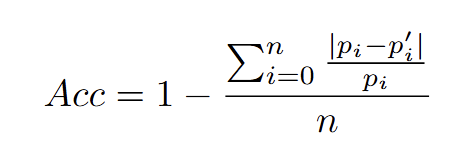

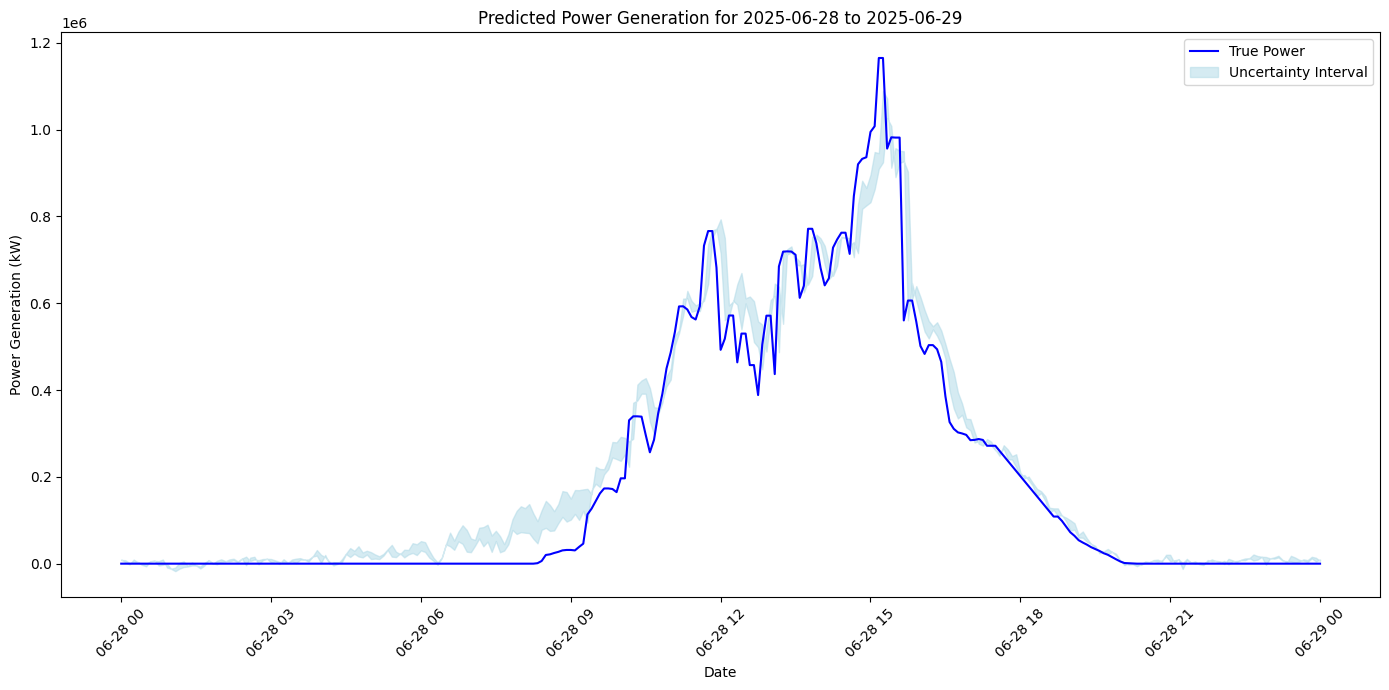

121
121
2025-06-28早上八点到下午六点的功率预测准确率: 88.41%
2025-06-04 08:00-18:00 准确率: 91.92%
2025-06-05 08:00-18:00 准确率: 92.50%
2025-06-06 08:00-18:00 准确率: 84.72%
2025-06-07 08:00-18:00 准确率: 79.93%
2025-06-08 08:00-18:00 准确率: 81.69%
2025-06-09 08:00-18:00 准确率: 78.20%
2025-06-10 08:00-18:00 准确率: 88.45%
2025-06-11 08:00-18:00 准确率: 86.96%
2025-06-12 08:00-18:00 准确率: 88.10%
2025-06-13 08:00-18:00 准确率: 86.97%
2025-06-14 08:00-18:00 准确率: 87.67%
2025-06-15 08:00-18:00 准确率: 88.34%
2025-06-16 08:00-18:00 准确率: 87.54%
2025-06-17 08:00-18:00 准确率: 78.47%
2025-06-18 08:00-18:00 准确率: 81.36%
2025-06-19 08:00-18:00 准确率: 90.94%
2025-06-20 08:00-18:00 准确率: 91.76%
2025-06-21 08:00-18:00 准确率: 87.76%
2025-06-22 08:00-18:00 准确率: 81.28%
2025-06-23 08:00-18:00 准确率: 80.86%
2025-06-24 08:00-18:00 准确率: 84.18%
2025-06-25 08:00-18:00 准确率: 87.29%
2025-06-26 08:00-18:00 准确率: 78.64%
2025-06-27 08:00-18:00 准确率: 89.51%
2025-06-28 08:00-18:00 准确率: 88.90%
2025-06-29 08:00-18:00 准确率: 85.20%
2025-06-30 08:00-18:00 准确率: 83.73%
2025-07-01 

In [16]:
#进行可视化：针对2025年4月27日-4月28日的24小时进行可视化：
start_date = "2025-06-28"
end_date = "2025-06-29"
threshold = 0 # 10000
# 过滤预测结果
filtered_forecast = forecast[(forecast["ds"] >= start_date) & (forecast["ds"] <= end_date)]

# 绘制预测结果
plt.figure(figsize=(14, 7))
plt.plot(filtered_forecast["ds"], filtered_forecast["y"], label="True Power", color='blue')
plt.fill_between(filtered_forecast["ds"], 
                 filtered_forecast["yhat1"], 
                 filtered_forecast["yhat2"], 
                 color='lightblue', alpha=0.5, label='Uncertainty Interval')
plt.title(f"Predicted Power Generation for {start_date} to {end_date}")

plt.xlabel("Date")
plt.ylabel("Power Generation (kW)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("neuralprophet_prediction_plot.png")
plt.show()
# 打印预测结果的前几行

start_time = f"{start_date} 08:00:00"
end_time = f"{start_date} 18:00:00"
# 过滤时间范围内的预测结果
filtered_forecast_time = filtered_forecast[(filtered_forecast["ds"] >= start_time) & (filtered_forecast["ds"] <= end_time)]
# n=len(filtered_forecast_time)
# #计算相对误差的和：
# relative_error_sum = np.sum(np.abs(filtered_forecast_time["y"] - filtered_forecast_time["yhat1"]) / filtered_forecast_time["y"])
# acc=1-relative_error_sum/n
#计算不为零的点处的正确率，如果为零的时间点，则不计算
selected_time=filtered_forecast_time[filtered_forecast_time["y"] >= threshold]
print(len(filtered_forecast_time))
print(len(selected_time))
#计算不为零的点处的相对误差
n = np.sum(selected_time["y"] != 0)
# print(n)
# print(np.abs(selected_time["y"] - selected_time["yhat1"]))
relative_error_sum = np.sum(np.abs(selected_time["y"] - selected_time["yhat1"]) )
sum_power = np.sum(selected_time["y"])
acc=1-relative_error_sum/sum_power
print(f"{start_date}早上八点到下午六点的功率预测准确率: {acc:.2%}")



# 把整个六月份的acc都计算出来，按照单日的，然后求平均
# 遍历6月的每一天，计算每天08:00-18:00的功率预测准确率，并求平均
from datetime import datetime, timedelta

# 6月的天数（2025年6月为30天）
start_month = "2025-06-04"
end_month = "2025-07-01"
date_list = pd.date_range(start=start_month, end=end_month, freq='D')
weight_acc = []
totol_power = []
acc_list = []
for single_date in date_list:
    day_str = single_date.strftime("%Y-%m-%d")
    # 过滤出当天的预测结果
    day_forecast = forecast[(forecast["ds"] >= f"{day_str} 00:00:00") & (forecast["ds"] <= f"{day_str} 23:59:59")]
    # 只取08:00-18:00
    start_time = f"{day_str} 08:00:00"
    end_time = f"{day_str} 18:00:00"
    day_time_forecast = day_forecast[(day_forecast["ds"] >= start_time) & (day_forecast["ds"] <= end_time)]
    # 只统计y不为0的点
    selected = day_time_forecast[day_time_forecast["y"] > threshold]
    # n = np.sum(selected["y"] != 0)
    if n == 0:
        acc = np.nan
    else:
        # relative_error_sum = np.sum(np.abs(selected["y"] - selected["yhat1"]) / selected["y"])
        # totol_power.append(np.sum(selected["y"]))
        # acc = 1 - relative_error_sum / n

        relative_error_sum =  np.sum(np.abs(selected["y"] - selected["yhat1"]))
        all_y = np.sum(selected["y"])
        totol_power.append(np.sum(selected["y"]))
        # print(relative_error_sum)
        acc = 1 - relative_error_sum / all_y
        # print(acc)
    acc_list.append(acc)
    print(f"{day_str} 08:00-18:00 准确率: {acc:.2%}" if not np.isnan(acc) else f"{day_str} 08:00-18:00 无有效数据")
    # print(f"{day_str} 08:00-18:00 准确率: {acc_weighted:.2%}" if not np.isnan(acc_weighted) else f"{day_str} 08:00-18:00 无有效数据")

# 计算6月平均准确率（去除无效天数）
valid_acc = [a for a in acc_list if not np.isnan(a)]
if valid_acc:
    avg_acc = np.mean(valid_acc)
    print(f"\n2025年6月整月（08:00-18:00）平均功率预测准确率: {avg_acc:.2%}")
    # 计算加权平均准确率
    if totol_power:
        weighted_acc = np.average(valid_acc, weights=totol_power)
        print(f"2025年6月整月（08:00-18:00）加权平均功率预测准确率: {weighted_acc:.2%}")
else:
    print("2025年6月无有效数据，无法计算平均准确率。")



In [17]:
np.sum(np.abs(filtered_forecast_time["y"] - filtered_forecast_time["yhat1"]) / filtered_forecast_time["y"])
filtered_forecast_time["y"]


7279         0.000000
7280         0.000000
7281         0.000000
7282         0.000000
7283      1080.000000
            ...      
7395    248300.428571
7396    236653.142857
7397    225005.857143
7398    213358.571429
7399    201711.285714
Name: y, Length: 121, dtype: float64